# Assignment 2

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: 
 - The assignment is due on Monday March 31st, 2025 at 23:55. 
 - Hand via DTU Learn. 
 - You should simply hand in the link to the github page with your short data story.

## A2: A short data story

This assignment is to create a short data-story based on the work we've done in class so far. See **Exercises Week 8, Part 2** for full details on how the story should be constructed.

## Part 1: Making the dataframe

This part reorganises the SFPD data by finding reports with the same report ID (ie crimes that relate to eachother) and compiles all column values associated with that report ID into lists organised by Date

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#load the data
df = pd.read_csv('PDReports_2003_2024.csv')  # Assuming the data is in a CSV file

# filter data to only include rows with non-unique values in 'Incident Number'
df = df[df.duplicated('Incident Number', keep=False)]

# remove ones with the same Time ie. has same incident number bcuz officer filed multiple reports
df = df[~df.duplicated(subset=['Incident Number', 'Time'], keep=False)]

# now remove non unique ones
df = df[df.duplicated('Incident Number', keep=False)]

# remove ones with the same Time ie. has same incident number bcuz officer filed multiple reports
df = df[~df.duplicated(subset=['Incident Number', 'Longitude', 'Latitude'], keep=False)]

# now remove non unique ones
df = df[df.duplicated('Incident Number', keep=False)]

# list of unique crime types and their counts
# counts = df['Category'].value_counts()

# sort the dataset by 'Date' and 'Time'
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.time
df = df.sort_values(by=['Date', 'Time'])
df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)

# list of unique crime types and their counts
# counts = df['Category'].value_counts()

# apply the following to the dataframe
# 1. get all unique 'Incident Number' values
# 2. for each unique value, get a list of all entries with that value in 'Incident Number'
# 3. have column for incident number, list of dates and times, locations (lat, long), incident category
# 4. create a new dataframe with the above columns
unique_incidents = df['Incident Number'].unique()
incident_data = []

for incident in unique_incidents:
    incident_entries = df[df['Incident Number'] == incident]
    dates = incident_entries['Date'].tolist()
    times = incident_entries['Time'].tolist()
    longitudes = incident_entries['Longitude'].tolist()
    latitudes = incident_entries['Latitude'].tolist()
    categories = incident_entries['Category'].tolist()
    descriptions = incident_entries['Description'].tolist()
    disctricts = incident_entries['District'].tolist()
    dayOfWeeks = incident_entries['DayOfWeek'].tolist()
    
    # Append the data for this incident to the list
    incident_data.append({
        'Incident Number': incident,
        'Dates': dates,
        'Times': times,
        'DayOfWeeks': dayOfWeeks,
        'Categories': categories,
        'Descriptions': descriptions,
        'Longitudes': longitudes,
        'Latitudes': latitudes,
        'Districts': disctricts
    })

incident_data = pd.DataFrame(incident_data)

# incident_data['Categories'].value_counts()

# filter the dataframe to only include rows with 'Categories' containing 'Vehicle Theft' in first position and 'Vehicle Related' in second position
carJobs = incident_data[incident_data['Categories'].apply(lambda x: 'Vehicle Theft' == x[0] and 'Vehicle Related' == x[1])]

carJobs = carJobs[carJobs['Longitudes'].apply(lambda x: not (np.isnan(x[0]) or np.isnan(x[1])))]  

carJobs['pointpair'] = carJobs.apply(lambda x: [[x['Latitudes'][0], x['Longitudes'][0]],[x['Latitudes'][1], x['Longitudes'][1]]], axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_100\1151642155.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('PDReports_2003_2024.csv')  # Assuming the data is in a CSV file


In [2]:

carJobs.iloc[0]

Incident Number                                             60093142
Dates                                       [2006-01-24, 2006-01-27]
Times                                           [19:00:00, 01:56:00]
DayOfWeeks                                         [Tuesday, Friday]
Categories                          [Vehicle Theft, Vehicle Related]
Descriptions           [STOLEN AUTOMOBILE, VEHICLE, RECOVERED, AUTO]
Longitudes                     [-122.43120636226, -122.411339562557]
Latitudes                       [37.7883159249075, 37.7812707434494]
Districts                                       [NORTHERN, SOUTHERN]
pointpair          [[37.7883159249075, -122.43120636226], [37.781...
Name: 3, dtype: object

Some helper functions I made along the way, not all are used

In [3]:
import math

def delta(pointpair):
    return [pointpair[1][0]-pointpair[0][0], pointpair[1][1]-pointpair[0][1]]

def normaldelta(pointpair):
    d = delta(pointpair)
    dn = math.sqrt(d[0]**2 + (d[1])**2)
    return [d[0]/dn, d[1]/dn]

def getAngle(pointpair):
    d = delta(pointpair)
    dn = math.sqrt(d[0]**2 + (d[1])**2)
    d = [d[0]/dn, d[1]/dn]  # Normalize the vector
    angle = math.atan2(d[0], d[1])
    return angle

def cutoff(pointpair, cutoff=0.1):
    d = delta(pointpair)
    new_destination = [pointpair[0][0] + d[0]*cutoff, pointpair[0][1] + d[1]*cutoff]
    return [pointpair[0],new_destination]

# method that takes a pointpair
# returns the first point
# returns a second point that is a set distance from the first point in the direction of the second point
def normalcutoff(pointpair, length=0.01):
    d = delta(pointpair)
    dn = math.sqrt(d[0]**2 + (d[1])**2)
    d = [d[0]/dn, d[1]/dn]  # Normalize the vector
    new_destination = [pointpair[0][0] + d[0]*length, pointpair[0][1] + d[1]*length]
    return [pointpair[0],new_destination]

# pointpair reorganises the latitudes and longitudes columns into one column of a nested list [[lat1, long1], [lat2, long2]]
carJobs['pointpair'].head(20).apply(lambda x: delta(normalcutoff(x)))
# arrow is the angle of the vector from the first point to the second point in radians
carJobs['arrow'] = carJobs['pointpair'].apply(lambda x: getAngle(x))

## The heatmap plots

This makes a heatmap of car thefts for each district
District gets marked by a blue line
Heatmap shows where cars have been found that have been stolen from that district

In [4]:
# make a heat map using folium
import folium
from folium.plugins import HeatMap
import json

# Load GeoJSON data
with open("sfpd.geojson", "r") as f:
    geo_data = json.load(f)

unique_districts = carJobs['Districts'].apply(lambda x: x[0]).unique()
#unique_districts = ['BAYVIEW']
for district in unique_districts:
    subset = carJobs[carJobs['Districts'].apply(lambda x: x[0] == district)]
    filtered_geojson = {
        "type": "FeatureCollection",
        "features": [f for f in geo_data["features"] if f["properties"]["DISTRICT"] == district]
    }

    # Create a map centered at an average location
    m = folium.Map(location=[37.7749, -122.4194],tiles='Cartodb Positron', zoom_start=12)

    # Add GeoJSON layer to the map
    folium.GeoJson(filtered_geojson,name="GeoJSON Layer").add_to(m)

    # Create a list of points for the heatmap
    heat_data = []
    for index, row in subset.iterrows():
        heat_data.append(row['pointpair'][1])

    # Create a heatmap layer
    HeatMap(heat_data, radius=12).add_to(m)

    # Display the map
    m.save(f'heatmap_{district}.html')
# Display the map


## Extra, use wherever you want to

Cool plot about what directions cars stolen from a given district have been found

C:\Users\User\AppData\Local\Temp\ipykernel_100\2067024088.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(num_rows, num_columns, i + 1, polar=True)


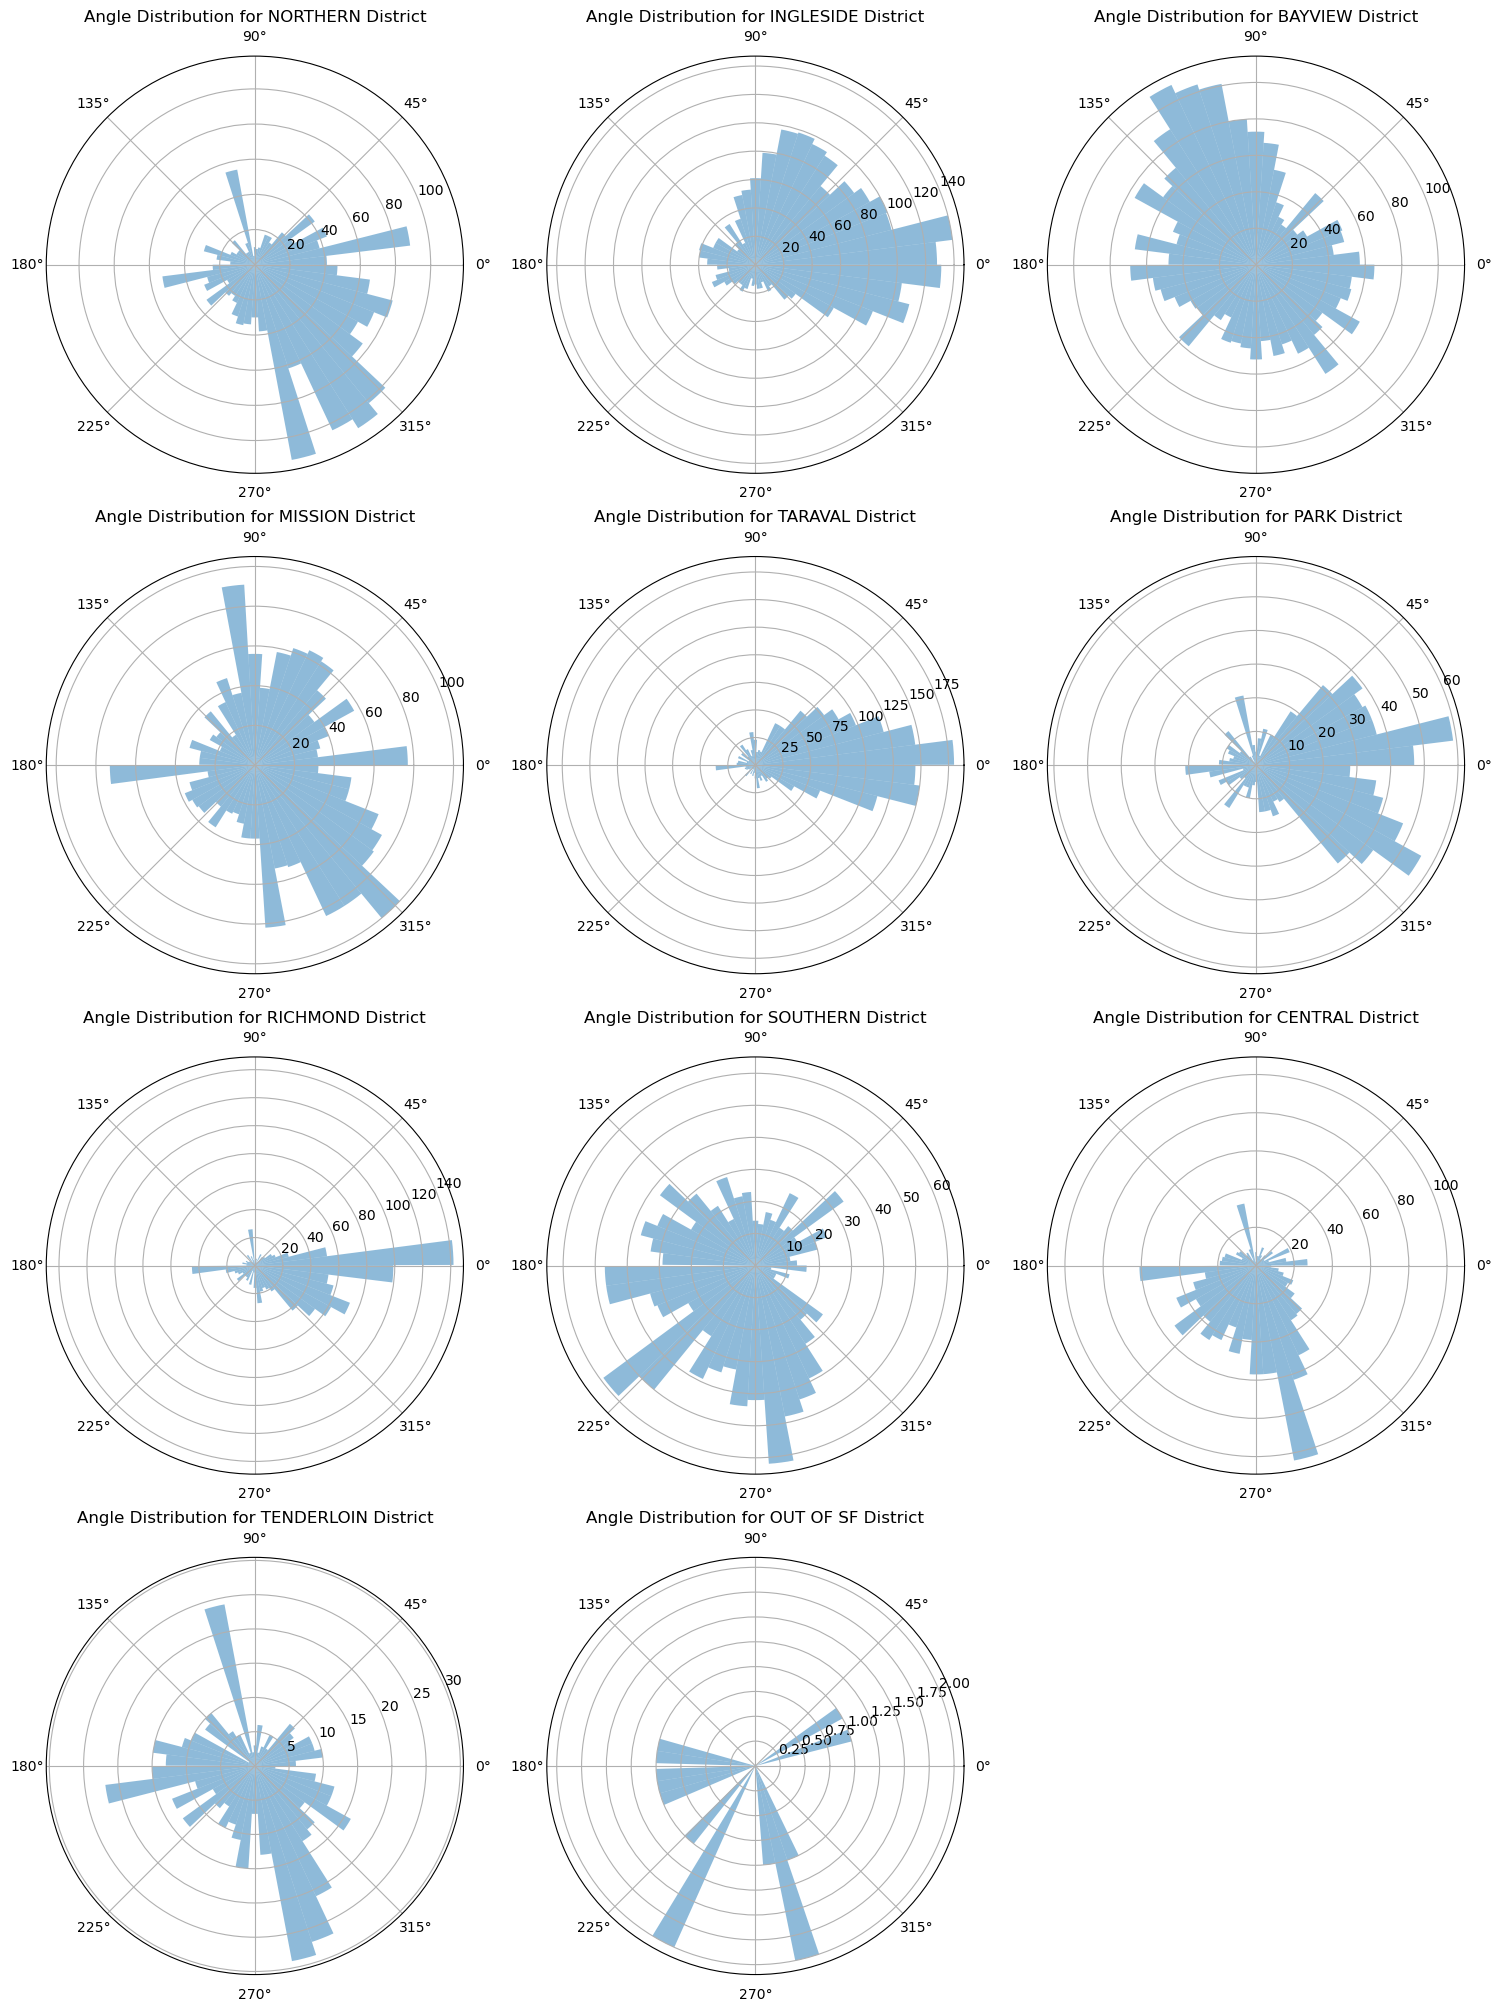

In [5]:
unique_districts = carJobs['Districts'].apply(lambda x: x[0]).unique()
num_districts = len(unique_districts)
num_columns = 3
num_rows = (num_districts + num_columns - 1) // num_columns  # Calculate rows needed

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, district in enumerate(unique_districts):
    ax = axes[i]
    ax = plt.subplot(num_rows, num_columns, i + 1, polar=True)
    ax.hist(carJobs[carJobs['Districts'].apply(lambda x: x[0]) == district]['arrow'], bins=50, alpha=0.5)
    ax.set_title(f'Angle Distribution for {district} District')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()

Plot that shows the distance distribution (how far they have been found) of all car thefts

<AxesSubplot: >

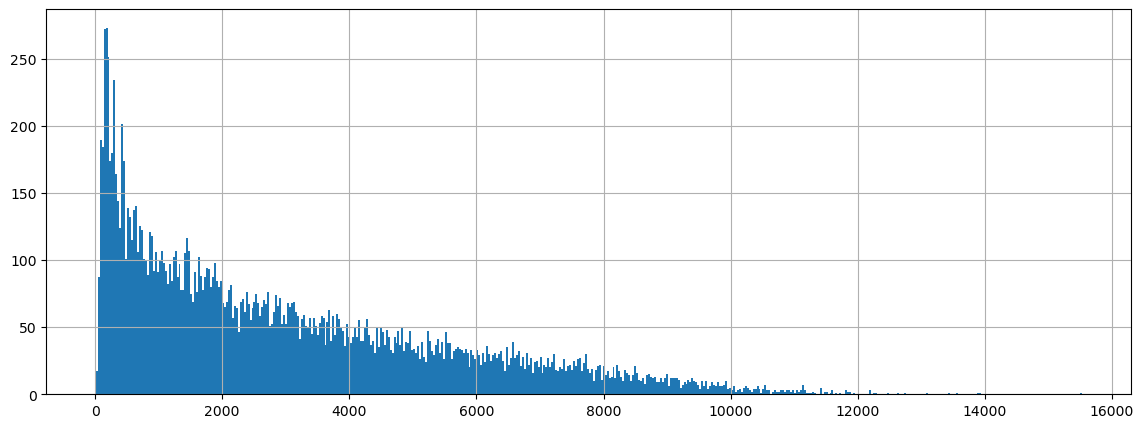

In [6]:
import math

def approx_distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    lat_factor = 111320  # Meters per degree latitude
    lon_factor = 111320 * math.cos(math.radians(lat1))  # Adjust for latitude

    dx = (lon2 - lon1) * lon_factor
    dy = (lat2 - lat1) * lat_factor

    return math.sqrt(dx**2 + dy**2)

carJobs['Distance'] = carJobs['pointpair'].apply(lambda x: approx_distance(x[0],x[1]))
carJobs['Distance'].describe()

plt.figure(figsize=(14, 5))
#carJobs['Distance'].hist(bins=500)
carJobs[carJobs['Distance'] > 1]['Distance'].hist(bins=500)